In [1]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp
import numpy as np
import numpy.linalg as la
from argparse import Namespace
import matplotlib.pyplot as plt

In [2]:
parameters = dict(K=25, ri=np.zeros(3), vi=np.zeros(3), ai=np.zeros(3),
                  rf=np.array([.4,.0,0]), vf=np.zeros(3), af=np.zeros(3),
                  wp=np.array([.2,.1,0]), wp_idx=11,
                  gravity=np.array([0.,0.,-9.81]),
                  v_max=.8, a_min=4., a_max=12.0, 
                  theta_max=np.radians(45.0),
                  j_max=50, max_iter=30,
                  weight_ri=1e3, weight_rf=1e4, weight_wp=1e4,
                  weight_obs=1e2, weight_trust=1e-1, n_obs=1)

""" Initialize parameters """
P = Namespace(**parameters)

ri = cp.Parameter(3)
vi = cp.Parameter(3)
ai = cp.Parameter(3)
rf = cp.Parameter(3)
vf = cp.Parameter(3)
af = cp.Parameter(3)
wp = cp.Parameter(3)

# w_obs = cp.Parameter()
# w_ri = cp.Parameter()
w_rf = cp.Parameter()
w_wp = cp.Parameter()
w_trust = cp.Parameter()

ri.value = P.ri
vi.value = P.vi
ai.value = P.ai
rf.value = P.rf
vf.value = P.vf
af.value = P.af
wp.value = P.wp

# w_obs.value = P.weight_obs
# w_ri.value = P.weight_ri
w_rf.value = P.weight_rf
w_wp.value = P.weight_wp
w_trust.value = P.weight_trust

""" Initialize variables """
r = cp.Variable((P.K, 3))
v = cp.Variable((P.K, 3))
a = cp.Variable((P.K, 3))
dtau = cp.Variable()

r0 = cp.Parameter((P.K, 3))
v0 = cp.Parameter((P.K, 3))
a0 = cp.Parameter((P.K, 3))
tau = cp.Parameter()

s = cp.Variable(P.K, nonneg=True)
eta = cp.Variable((P.K, P.n_obs), nonneg=True)
delta = cp.Variable((P.K, 2), nonneg=True)
trust = cp.Variable(nonneg=True)

rf_relax = cp.Variable(3)
ri_relax = cp.Variable(3)
wp_relax = cp.Variable(3)

s_ri = cp.Variable()
s_rf = cp.Variable()
s_wp = cp.Variable()
f = 0
g = dict() 
sigma = cp.Variable(nonneg=True)
# helper variables to maintain disciplined parametric programming
raccel = cp.Variable((P.K-1, 3))
Dt_raccel = cp.Variable((P.K-1, 3))


def update(r,v,a,t):
    r0.value = r
    v0.value = v
    a0.value = a
    tau.value = t
    
update(np.zeros((P.K,3)), 
       np.zeros((P.K,3)), 
       np.zeros((P.K,3)), 
       0.02)

""" Define cost """
# f += cp.norm(s)
f += tau + dtau
# f += w_ri*s_ri
f += w_rf*s_rf
f += w_wp*s_wp
f += w_trust*trust

# g["relax_ri"] = s_ri >= cp.norm(ri_relax)
g["relax_rf"] = s_rf >= cp.norm(rf_relax)
g["relax_wp"] = s_wp >= cp.norm(wp_relax)

""" Trust Region """
g["trust_dtau"] = cp.abs(dtau) <= trust
# g["trust_pos"] = cp.abs(r[:,:2] - r0[:,:2]) <= delta
# g["trust_obs"] = cp.sum(delta) <= trust

""" Boundary conditions """
g["pos_initial"] = r[0] == ri #+ ri_relax
g["pos_final"] = r[-1] == rf + rf_relax
g["vel_initial"] = v[0] == vi
g["vel_final"] = v[-1] == vf
g["waypoint"] = r[P.wp_idx] == wp + wp_relax
g["accel_initial"] = a[0,:2] == ai[:2]
g["accel_final"] = a[-1,:2] == af[:2]

""" Dynamics """
grav = np.tile(P.gravity, (P.K-1, 1)) 
g["helper_raccel"] = raccel == 1/2*(1/3*(2*a[:-1] + a[1:]) + grav)*tau
g["helper_Dt_raccel"] = Dt_raccel == (1/3*(2*a0[:-1] + a0[1:]) + grav)*dtau
g["dynamics_pos"] = \
r[1:] == r[:-1] + (v[:-1] + raccel)*tau + v0[:-1]*dtau + Dt_raccel*tau
g["dynamics_vel"] = \
v[1:] == v[:-1] + 1/2*(a[:-1] + a[1:] + grav)*tau \
       + 1/2*(a0[:-1] + a0[1:] + grav)*dtau# + v_virtual

""" State constraints """
#g += [P.cpos_A@@r <= np.tile(P.cpos_b, (K,1))]
g["height_max"] = r[:,2] <= 0
g["height_min"] = -r[:,2] >= 0
# g["vertical_vel"] = cp.abs(v[:,2]) <= 0
g["vel_max"] = cp.norm(v, axis=1) <= P.v_max

g["horizontal_jerk_max"] = cp.norm(a[:-1] - a[1:], 2, axis=1) <= P.j_max*(tau + dtau)

g["lossless"] = cp.norm(a, axis=1) <= s
g["bank_angle"] = np.cos(P.theta_max)*s <= a[:,2]
g["thrust_min"] = P.a_min <= s 
g["thrust_max"] = s <= P.a_max

prob = cp.Problem(cp.Minimize(f), list(g.values()))

for _ in range(P.max_iter):
    out = prob.solve(solver="SCS")
    if out == np.inf:
        print("FAILED")
        break
    print(f"""T={P.K*tau.value:.2f}s \
            | trust={trust.value:.5f} \
            | rf_relax={la.norm(rf_relax.value):.5f} \
            | wp_relax={la.norm(wp_relax.value):.5f}""")
    if np.isclose(trust.value,0):
        break
    update(r.value, v.value, a.value, tau.value + dtau.value)

T=0.50s             | trust=0.02205             | rf_relax=0.16466             | wp_relax=0.12327
T=1.05s             | trust=0.00999             | rf_relax=0.00268             | wp_relax=0.00883
T=1.30s             | trust=0.01355             | rf_relax=0.00034             | wp_relax=0.00018
T=0.96s             | trust=0.00219             | rf_relax=0.00181             | wp_relax=0.00217
T=1.02s             | trust=0.00274             | rf_relax=0.00122             | wp_relax=0.00100
T=0.95s             | trust=0.00035             | rf_relax=0.00053             | wp_relax=0.00015
T=0.94s             | trust=0.00008             | rf_relax=0.00061             | wp_relax=0.00009
T=0.94s             | trust=0.00008             | rf_relax=0.00063             | wp_relax=0.00009
T=0.94s             | trust=0.00003             | rf_relax=0.00064             | wp_relax=0.00009
T=0.94s             | trust=0.00000             | rf_relax=0.00063             | wp_relax=0.00009


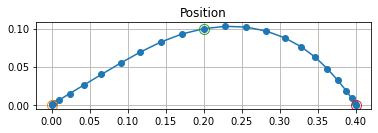

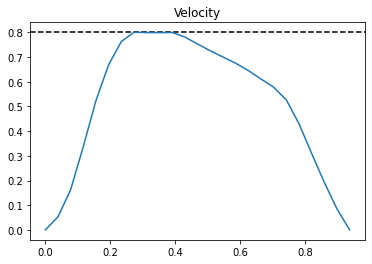

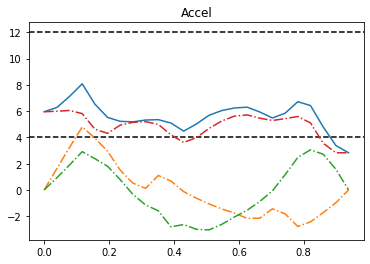

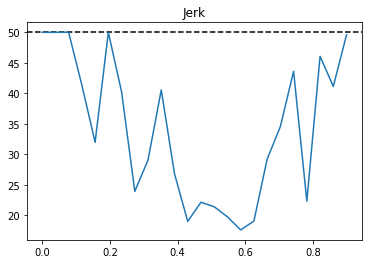

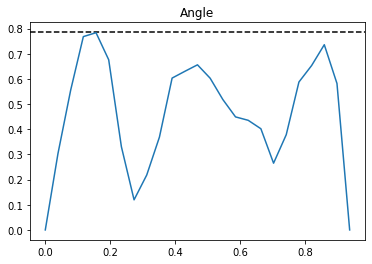

In [3]:
t = np.linspace(0,P.K*tau.value,P.K) 
plt.figure()
plt.title("Position")
plt.plot(*r.value[:,:2].T, 'o-')
plt.plot(*ri.value[:2], 'o', fillstyle='none', ms=10)
plt.plot(*wp.value[:2], 'o', fillstyle='none', ms=10)
plt.plot(*rf.value[:2], 'o', fillstyle='none', ms=10)
plt.gca().set_aspect('equal')
plt.grid()
#plt.plot(r.value[:,2], 'o-')
plt.figure()
plt.title("Velocity")
plt.gca().axhline(y=P.v_max, color='k', ls='--')
plt.plot(t, la.norm(v.value, axis=1))
# plt.plot(t, v.value, '-.')
plt.figure()
plt.title("Accel")
plt.gca().axhline(y=P.a_min, color='k', ls='--')
plt.gca().axhline(y=P.a_max, color='k', ls='--')
plt.plot(t, la.norm(a.value, axis=1))
plt.plot(t, a.value, '-.')
plt.figure()
plt.title("Jerk")
plt.gca().axhline(y=P.j_max, color='k', ls='--')
plt.plot(t[:-1], la.norm(np.diff(a.value, axis=0), axis=1)/tau.value)
#plt.plot(t, a.value, '-.')
plt.figure()
plt.title("Angle")
plt.gca().axhline(y=P.theta_max, color='k', ls='--')
bank_angle = np.arccos(a.value.dot(-P.gravity)/(la.norm(a.value,axis=1)*la.norm(P.gravity)))
plt.plot(t, bank_angle)
plt.show()

In [4]:
g["vel_max"].dual_value

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.89634293e-04, 0.00000000e+00, 2.89634293e-04, 1.34105236e+01,
       4.51971797e-01, 2.89634293e-04, 3.62709976e+00, 2.89634293e-04,
       2.89634293e-04, 2.89634293e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.89634293e-04, 2.89634293e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [5]:
g["horizontal_jerk_max"].dual_value

array([0.6648332 , 0.32559138, 0.10428193, 0.        , 0.        ,
       0.021024  , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])